## # Part 1: Dataset Description and Collection

In [38]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os, math, hashlib
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image


# ===== MULTI-ROOT SCAN =====

IMAGE_EXTS = ('.png','.jpg','.jpeg','.tif','.tiff','.bmp')

ROOTS = [
    "/kaggle/input/bach-breast-cancer-histology-images",             
    "/kaggle/input/bach-breast-cancer-histology-images/ICIAR2018_BACH_Challenge_TestDataset"
]

def scan_root(root):
    paths, total = [], 0
    for dp, dn, fn in os.walk(root):
        low = dp.lower()
        if "thumbnail" in low:           # skip obvious thumbnails
            continue
        for f in fn:
            if f.lower().endswith(IMAGE_EXTS):
                p = os.path.join(dp, f)
                paths.append(p)
                try:
                    total += os.path.getsize(p)
                except OSError:
                    pass
    return paths, total

per_root = []
all_paths = []
for r in ROOTS:
    ps, sz = scan_root(r)
    per_root.append({"root": r, "images": len(ps), "size_gb": sz/(1024**3)})
    all_paths.extend(ps)

per_root_df = pd.DataFrame(per_root).sort_values("size_gb", ascending=False).reset_index(drop=True)
display(per_root_df)

total_gb = sum(per_root_df["size_gb"])
print(f"Total number of images: {len(all_paths):,}")
print(f"Total size:   {total_gb:.2f} GB")

# ===== LABEL INFERENCE  =====

LABEL_KEYWORDS = {
    "benign": {"benign"},
    "malignant": {"malignant","cancer","carcinoma","tumor","tumour"},
    "normal": {"normal","control"},
    "invasive": {"invasive"},
    "in_situ": {"in-situ","in_situ","insitu","dcis"},
}
token2lbl = {t:k for k, toks in LABEL_KEYWORDS.items() for t in toks}

def infer_label_from_path(p):
    parts = [x.lower() for x in p.replace("\\","/").split("/")]
    for part in parts:
        if part in token2lbl:
            return token2lbl[part]
    for part in parts:
        for lbl, toks in LABEL_KEYWORDS.items():
            if any(t in part for t in toks):
                return lbl
    parent = os.path.basename(os.path.dirname(p)).lower()
    for lbl, toks in LABEL_KEYWORDS.items():
        if any(t in parent for t in toks):
            return lbl
    return None

# Run on ALL images (for Part-1 totals)
df = pd.DataFrame({"path": all_paths})
df["label"] = df["path"].map(infer_label_from_path)
df.head()




,root,images,size_gb
0,/kaggle/input/bach-breast-cancer-histology-images,500,8.622246
1,/kaggle/input/bach-breast-cancer-histology-ima...,100,1.757848


Total number of images: 600
Total size:   10.38 GB


,path,label
0,/kaggle/input/bach-breast-cancer-histology-ima...,malignant
1,/kaggle/input/bach-breast-cancer-histology-ima...,malignant
2,/kaggle/input/bach-breast-cancer-histology-ima...,malignant
3,/kaggle/input/bach-breast-cancer-histology-ima...,malignant
4,/kaggle/input/bach-breast-cancer-histology-ima...,malignant


## Part 2: Visualization of Data

,count
label,
malignant,200
in_situ,100
benign,100
normal,100
invasive,100


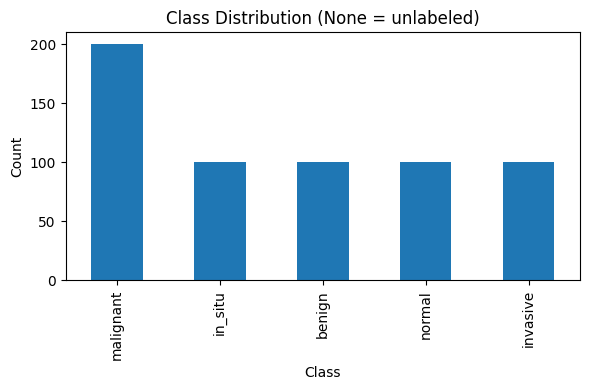

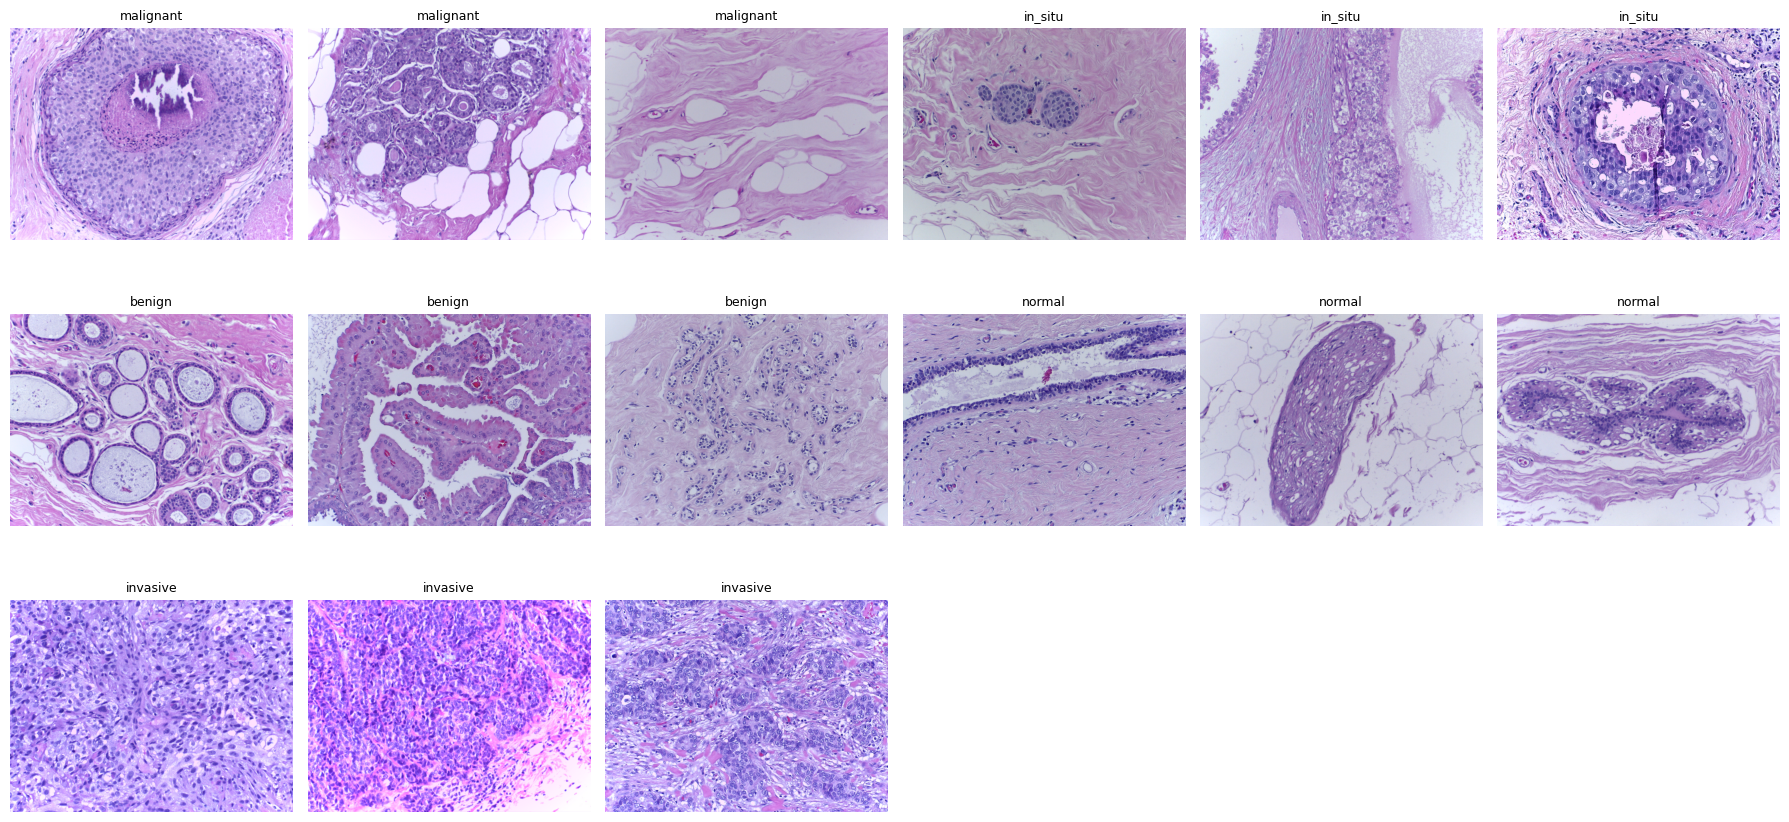

In [39]:
# ===== CLASS DISTRIBUTION + SAMPLE PREVIEWS =====
import matplotlib.pyplot as plt
from PIL import Image
import random

label_counts = df["label"].value_counts(dropna=False)
display(label_counts.to_frame("count"))

plt.figure(figsize=(6,4))
label_counts.plot(kind="bar")
plt.title("Class Distribution (None = unlabeled)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

def show_samples(df_subset, per_label=3, max_total=12):
    labels = [l for l in df_subset["label"].dropna().unique()]
    picks = []
    if labels:
        for l in labels:
            subset = df_subset[df_subset["label"] == l]["path"].tolist()
            random.shuffle(subset)
            picks += subset[:per_label]
    else:
        paths = df_subset["path"].tolist()
        random.shuffle(paths)
        picks = paths[:max_total]

    cols = min(6, len(picks)); rows = (len(picks)+cols-1)//cols
    plt.figure(figsize=(3*cols, 3*rows))
    for i, p in enumerate(picks, 1):
        try:
            with Image.open(p) as im:
                plt.subplot(rows, cols, i)
                plt.imshow(im); plt.axis("off")
                ttl = infer_label_from_path(p) or "unlabeled"
                plt.title(ttl, fontsize=9)
        except Exception:
            pass
    plt.tight_layout(); plt.show()

# Show previews for ALL (or per-batch)
show_samples(df)
# show_samples(df[df["path"].isin(two_batches[0])])  # preview batch 1
# show_samples(df[df["path"].isin(two_batches[1])])  # preview batch 2


## 